In [27]:
%reload_ext autoreload
%autoreload 2
import os, sys
sys.path.append('..')

import numpy as np
import healpy as hp
from tqdm.notebook import tqdm
import pickle
from astropy.io import fits

from astropy.coordinates import SkyCoord

import jax.numpy as jnp
from jax import jit, vmap

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [2]:
from utils.units_constants import *
from utils.cart import to_cart

## 1. Galactic longitude l and latitude b

In [14]:
CHIME_pixel_size = 15 * arcmin # rad

n_b_pix = int(jnp.round(jnp.pi/CHIME_pixel_size))
n_l_pix = int(jnp.round(2*jnp.pi/CHIME_pixel_size))
b_edge_s = jnp.linspace(-jnp.pi/2, jnp.pi/2, n_b_pix+1)
l_edge_s = jnp.linspace(-jnp.pi, jnp.pi, n_l_pix+1)
b_s = (b_edge_s[:-1] + b_edge_s[1:]) / 2 # bin centers
l_s = (l_edge_s[:-1] + l_edge_s[1:]) / 2 # bin centers

l_grid, b_grid = jnp.meshgrid(l_s, b_s)
lb_flat = jnp.stack([l_grid.flatten(), b_grid.flatten()], axis=-1)

## 2. Source (Haslam) map

In [5]:
haslam_dsds_map_hp = hp.read_map('../data/haslam_maps/haslam408_dsds_Remazeilles2014.fits')
haslam_dsds_map = hp.pixelfunc.get_interp_val(haslam_dsds_map_hp, l_grid/deg, b_grid/deg, lonlat=True)

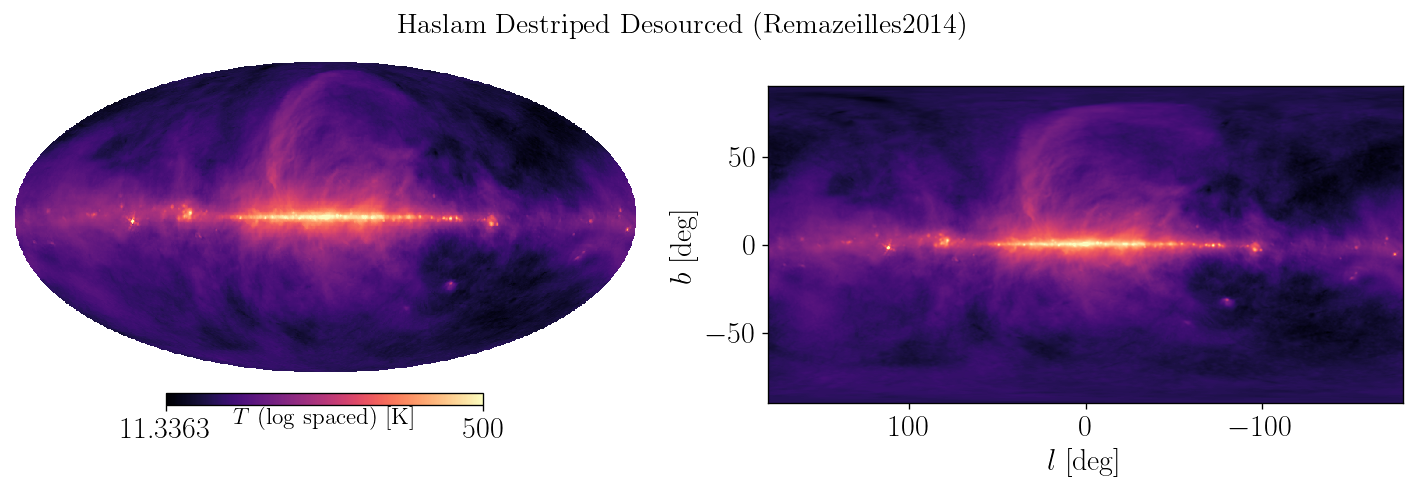

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15,4))

plt.axes(axs[0])
hp.mollview(haslam_dsds_map_hp, norm='log', unit=r'$T$ (log spaced) [K]', title='',
            cmap='magma', max=500, hold=True)
im = axs[1].imshow(np.flip(np.log10(haslam_dsds_map)), cmap='magma', vmax=np.log10(500),
              extent=(180, -180, -90, 90))
axs[1].set(xlabel=r'$l$ [deg]', ylabel=r'$b$ [deg]')
#fig.colorbar(im, ax=axs[1], shrink=0.8)

fig.suptitle('Haslam Destriped Desourced (Remazeilles2014)');

## 2. DM column integral

In [16]:
from utils.nfw import rho_integral, rho_integral_ref

In [17]:
%%time
rho_integral_flat = rho_integral(lb_flat)

CPU times: user 2.29 s, sys: 3.62 s, total: 5.91 s
Wall time: 3.16 s


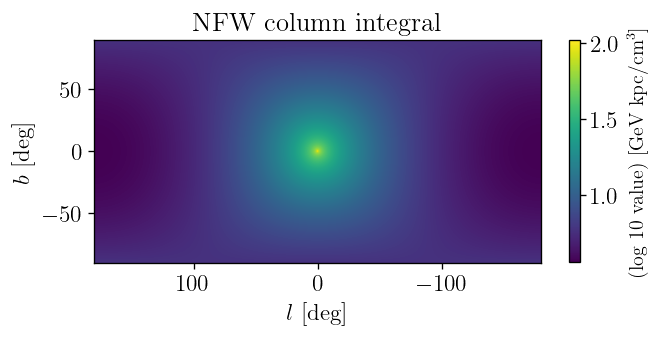

In [30]:
fig, ax = plt.subplots()
im = ax.imshow(jnp.log10(jnp.flip(rho_integral_flat.reshape(n_b_pix, n_l_pix))),
          extent=(180, -180, -90, 90))
ax.set(title='NFW column integral', xlabel=r'$l$ [deg]', ylabel=r'$b$ [deg]')
cbar = fig.colorbar(im, ax=ax, shrink=0.6)
cbar.set_label('(log 10 value) [GeV kpc/cm$^3$]', fontsize=12);

In [32]:
print(rho_integral_ref, '[GeV kpc/cm^3]')

4.5999994 [GeV kpc/cm^3]


## 3. Gegenschein temperature

Gegenschein intensity:
$$I_g=\hbar c^4\frac{g^2}{16}I_{\nu,0}\int\rho.$$
Specific intensity in interested frequency range:
$$I_{\nu,g}=\frac{f_\Delta}{\Delta\nu}\hbar c^4\frac{g^2}{16}I_{\nu,0}\int\rho.$$
Temperature
$$T_g=\frac{f_\Delta}{\Delta\nu}\hbar c^4\frac{g^2}{16}T_0\int\rho.$$
dimensions:
$$\text{[K]}=\frac{[1]}{\text{[MHz]}}\text{[cm}^2\text{ MHz GeV]}(\hbar c^2)\frac{[1]}{\text{[GeV]}^2}\text{[K]}\frac{\text{[GeV]}}{\text{[cm]}^2}(\int\rho c^2).$$

In [15]:
sigma_d = 116/3e5 # km s^-1/km s^-1
fDelta = 0.721 # [1]
Dnu = 2 * sigma_d * 408 # [MHz]
hbarc02 = 5.91571e-10 # [cm^2 MHz GeV]
c0 = 29979.2 # [cm MHz]
kpc = 3.08568e21 # [cm]
gagg = 6.6e-11 # [GeV^-1]

In [16]:
prefac = fDelta/Dnu * hbarc02 * (gagg**2/16) * kpc

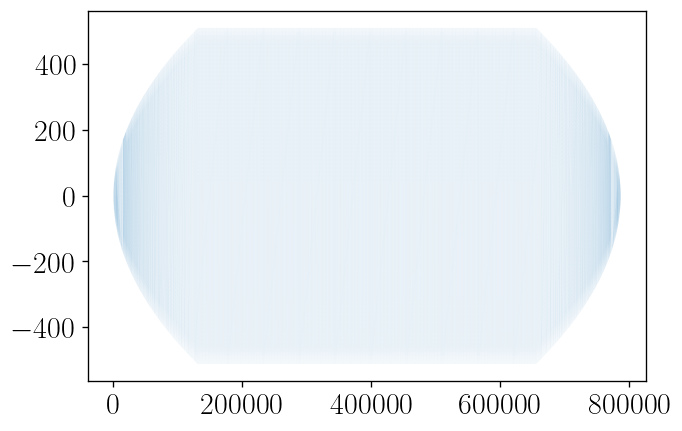

In [15]:
plt.plot(anti_inds - (NPIX-np.arange(NPIX)), linewidth=0.01);

In [17]:
# downsample Haslam map
dsds_map_downsample = hp.pixelfunc.ud_grade(dsds_map, NSIDE)

# antipodal Haslam map
anti_dsds_map = dsds_map_downsample[anti_inds]

# naive (reference) gegenschein temperature
gegen_temp_map = prefac * anti_dsds_map * rho_integral_map

# reference forward+front temperature # I_src * 10kpc uniform column with rho_NFW(r_Sun)
forward_temp_map = prefac * dsds_map_downsample * rho_integral_ref

In [18]:
np.save('gegen_temp_map.npy', gegen_temp_map)
np.save('forward_temp_map.npy', forward_temp_map)
np.save('dsds_map_downsample.npy', dsds_map_downsample)

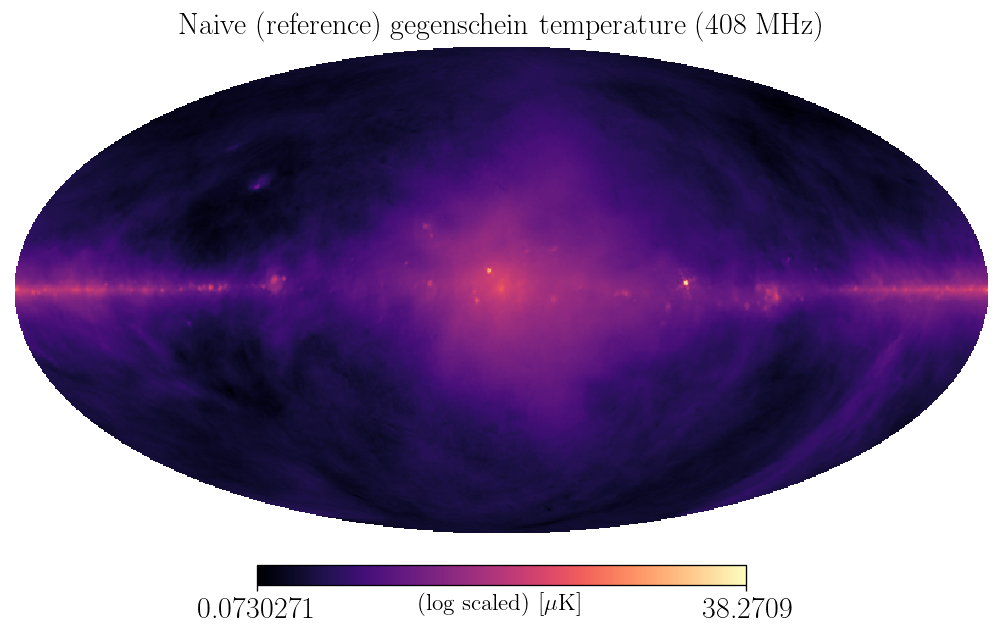

In [22]:
hp.mollview(1e6 * gegen_temp_map, norm='log', cmap='magma',
            title='Naive (reference) gegenschein temperature (408 MHz)',
            unit='(log scaled) [$\mu$K]')

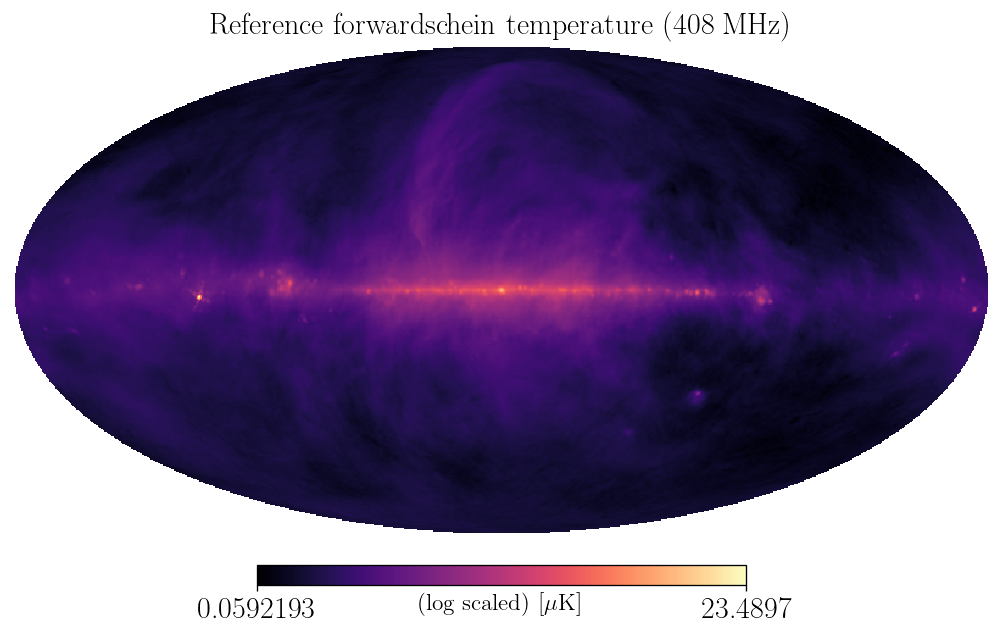

In [23]:
hp.mollview(1e6 * forward_temp_map, norm='log', cmap='magma',
            title='Reference forwardschein temperature (408 MHz)',
            unit='(log scaled) [$\mu$K]')

## 4. Exposure

In [19]:
t_baseline = 600 # [s]
exposure_C = t_baseline / np.abs(np.cos(b_s)) * (b_s > np.deg2rad(-20))

double_pass_b = np.deg2rad(70)
exposure_C *= (b_s > double_pass_b) + 1

In [20]:
# source: https://stackoverflow.com/questions/44443498/how-to-convert-and-save-healpy-map-to-different-coordinate-system
def change_coord(m, coord):
    """ Change coordinates of a HEALPIX map

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

In [21]:
exposure_G = change_coord(exposure_C, ['C', 'G'])

In [27]:
np.save('exposure_G.npy', exposure_G)

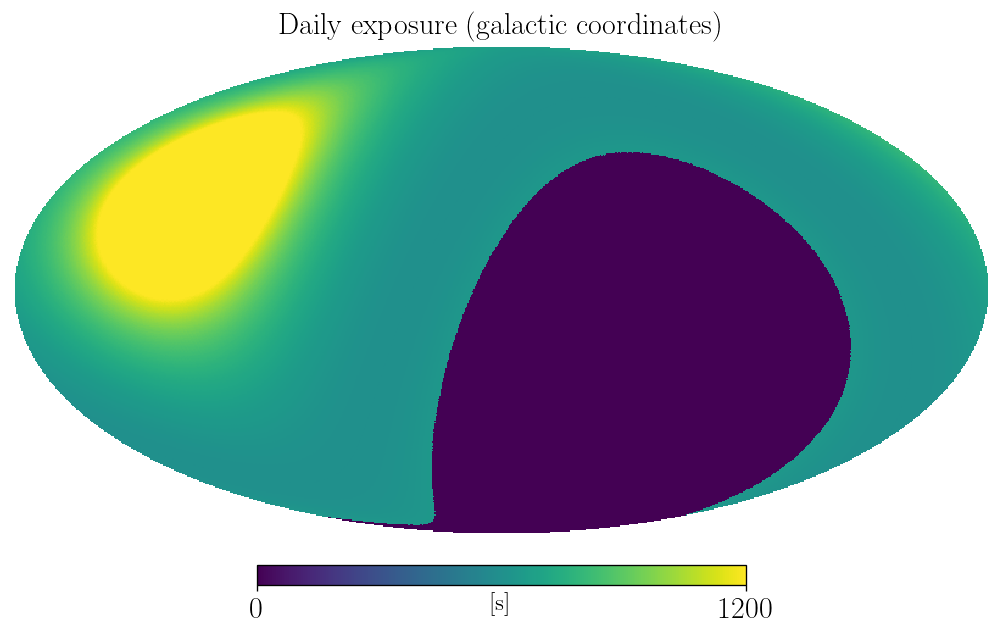

In [28]:
hp.mollview(exposure_G, min=0, max=1200, title='Daily exposure (galactic coordinates)', unit='[s]')

## 5. S/N

$$S/N = \sqrt{\sum_i (S/N_i)^2}$$

$$S/N_i=\frac{T_{g,i}}{T_{\text{sys},i}}\sqrt{2\Delta\nu~t_\text{obs}}$$

In [29]:
# approximate number of CHIME pixels on sky
n_chime_pix = 4*np.pi / ((np.pi/4)*np.deg2rad(15/60)**2)
print(n_chime_pix)

840398.4256030065


In [30]:
NPIX # just use this for now

786432

In [48]:
#T_sys_s = np.maximum(np.full_like(ds_map_downsample, 50), ds_map_downsample)
T_sys_s = 50 + dsds_map_downsample
SNR_g_s = gegen_temp_map * np.sqrt(2*Dnu*1e6*exposure_G*3.5*365.25) / T_sys_s
SNR_f_s = forward_temp_map * np.sqrt(2*Dnu*1e6*exposure_G*3.5*365.25) / T_sys_s
print('naive gegenschein:', np.sqrt(np.sum(SNR_g_s**2)))
print('reference forwardschein:', np.sqrt(np.sum(SNR_f_s**2)))

naive gegenschein: 1.9445174
reference forwardschein: 1.249932


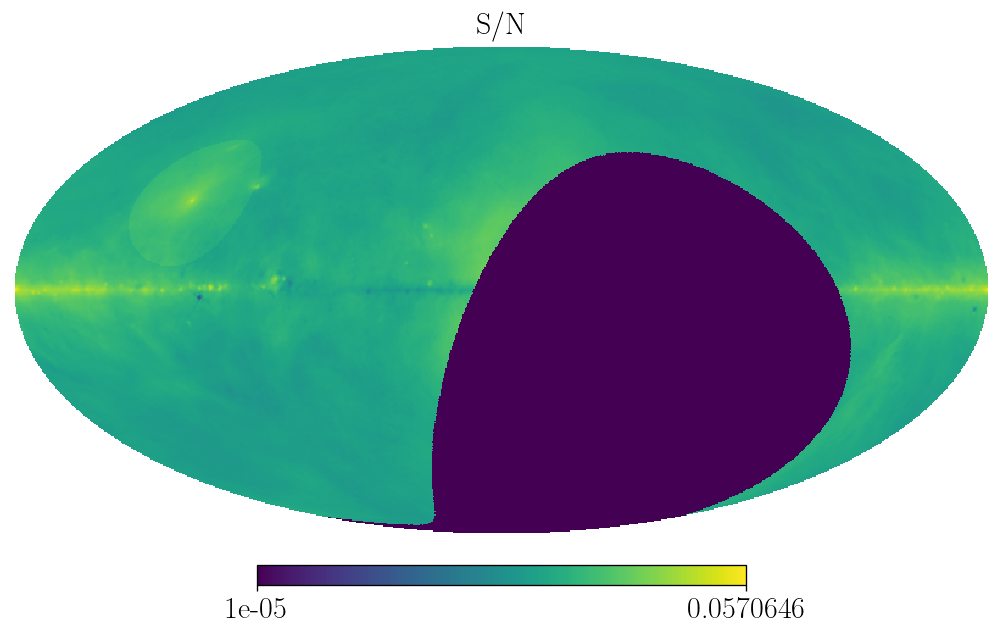

In [49]:
hp.mollview(np.clip(SNR_g_s, 1e-5, None), title='S/N', norm='log')

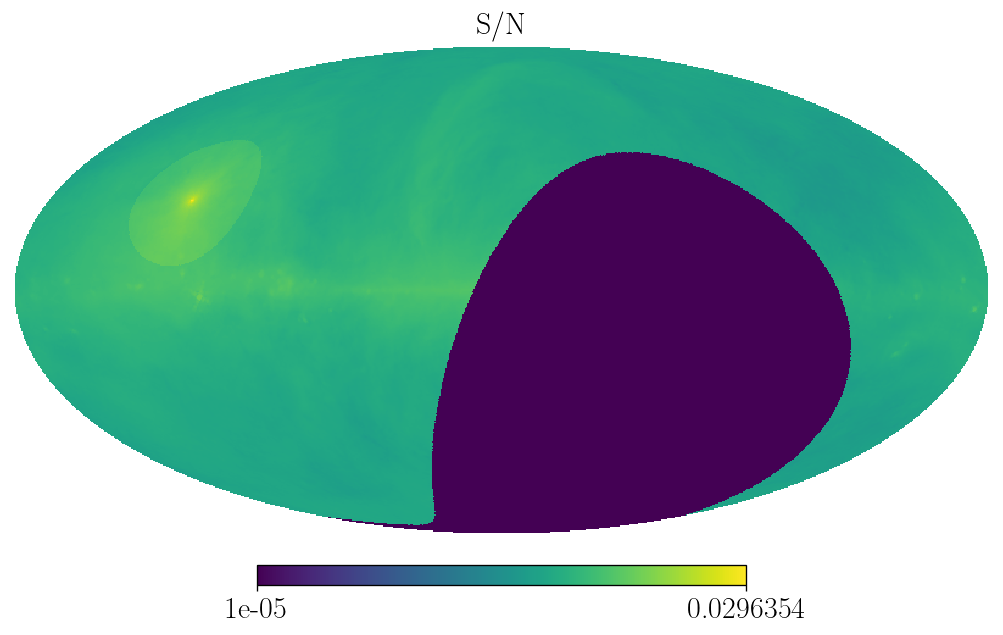

In [50]:
hp.mollview(np.clip(SNR_f_s, 1e-5, None), title='S/N', norm='log')

## 6. Modification to account for 3D model
Multiplying by ratio generated from 3D_model/galactic_synchrotron.ipynb

In [61]:
B_scheme = 'BS_H'

In [62]:
ratio_dict = pickle.load(open(f'../3D_model/ratios_{B_scheme}.dict', 'rb'))

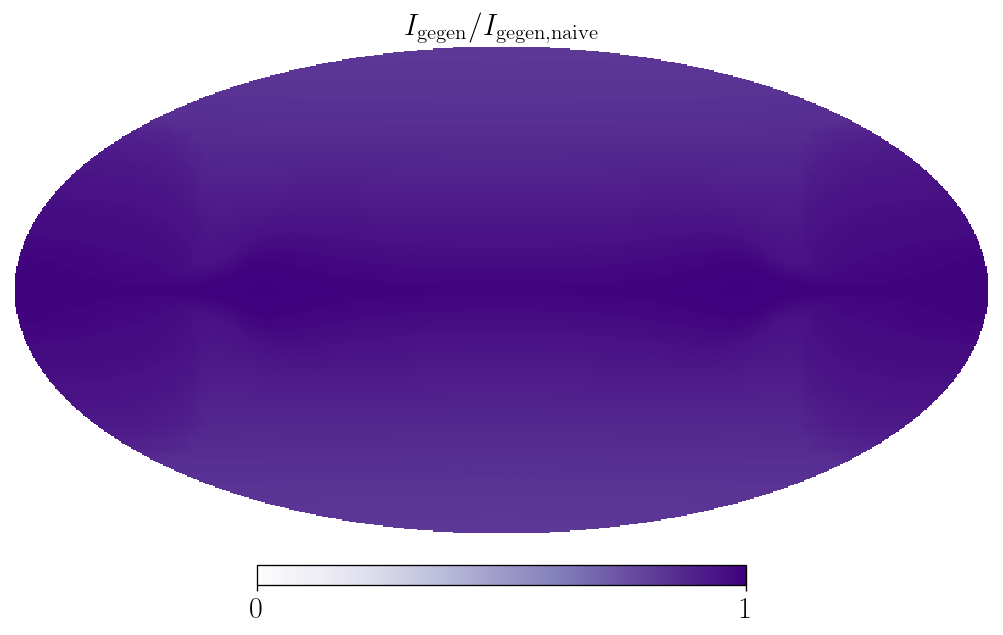

In [42]:
hp.mollview(ratio_dict['g_ratio'], title=r'$I_\mathrm{gegen}/I_\mathrm{gegen,naive}$', cmap='Purples', min=0, max=1)

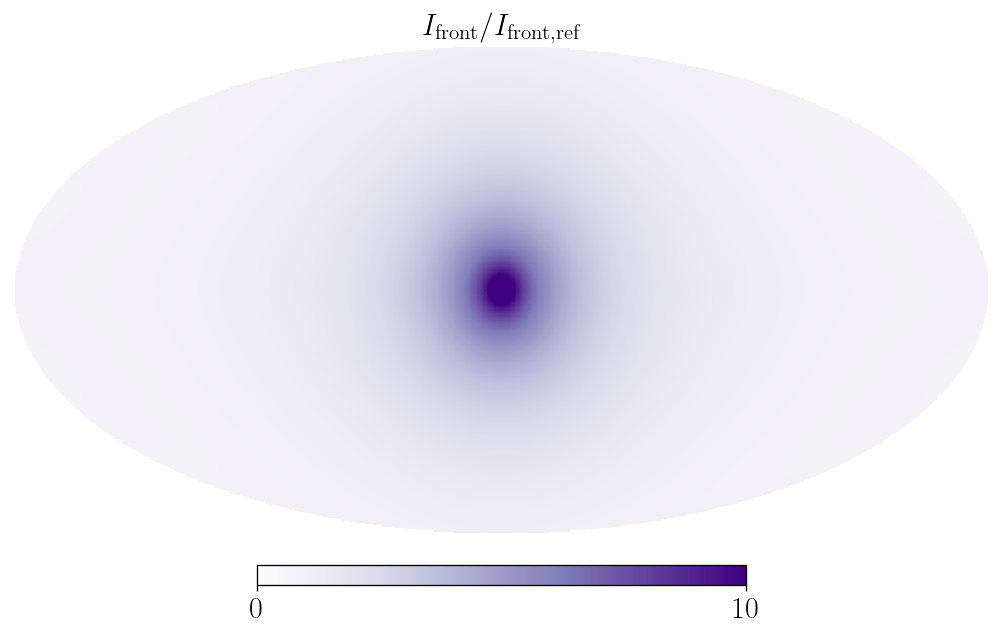

In [41]:
hp.mollview(ratio_dict['f_ratio'], title=r'$I_\mathrm{front}/I_\mathrm{front,ref}$', cmap='Purples', min=0, max=10)

In [ ]:
#hp.mollview(np.clip(SNR_s*ratio_map, 1e-5, None), title='S/N', norm='log')

In [63]:
tot_temp_map = gegen_temp_map * ratio_dict['g_ratio'] + forward_temp_map * ratio_dict['f_ratio']
np.save('tot_temp_map_BS', tot_temp_map)

In [64]:
SNR_tot_map = SNR_g_s * ratio_dict['g_ratio'] + SNR_f_s * ratio_dict['f_ratio']
np.sqrt(np.sum((SNR_tot_map)**2))

3.6183655

## 6. Frequency dependence

In [24]:
tot_temp_map_AR = np.load('../data/tot_temp_map_AR.npy')
tot_temp_map_BS = np.load('../data/tot_temp_map_BS.npy')
dsds_map_downsample = np.load('../data/dsds_map_downsample.npy')
exposure_G = np.load('../data/exposure_G.npy')

In [25]:
freq_s = np.linspace(400, 800, 30)
tot_SNR_s_AR = np.zeros_like(freq_s)
tot_SNR_s_BS = np.zeros_like(freq_s)
beta = -2.55

for i, freq in enumerate(tqdm(freq_s)):
    sig_temp_map = tot_temp_map_AR * (freq/408)**(beta-1)
    bkg_temp_map = 50 + dsds_map_downsample * (freq/408)**(beta)
    SNR_map = sig_temp_map * np.sqrt(2*Dnu*(freq/408)*1e6*exposure_G*3.5*365.25) / bkg_temp_map
    tot_SNR_s_AR[i] = np.sqrt(np.sum(SNR_map**2))
    
    sig_temp_map = tot_temp_map_BS * (freq/408)**(beta-1)
    bkg_temp_map = 50 + dsds_map_downsample * (freq/408)**(beta)
    SNR_map = sig_temp_map * np.sqrt(2*Dnu*(freq/408)*1e6*exposure_G*3.5*365.25) / bkg_temp_map
    tot_SNR_s_BS[i] = np.sqrt(np.sum(SNR_map**2))

  0%|          | 0/30 [00:00<?, ?it/s]

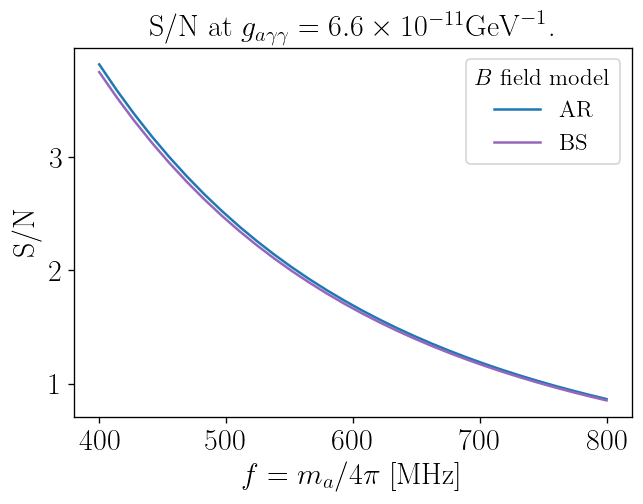

In [35]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(freq_s, tot_SNR_s_AR, label='AR', c='tab:blue')
ax.plot(freq_s, tot_SNR_s_BS, label='BS', c='tab:purple')
ax.set(xlabel=r'$f=m_a/4\pi$ [MHz]', ylabel='S/N',
       title=r'S/N at $g_{a\gamma\gamma}=6.6\times10^{-11}\mathrm{GeV}^{-1}$.')
ax.legend(title=r'$B$ field model');